In [ ]:
import numpy as np
import glob
import astropy
from astropy.io import fits
import os
from matplotlib import colors
import matplotlib.pyplot as plt
import casatasks
import casatools
import os
import sys
import subprocess

In [ ]:
data_location = "/fast/xhall/snapshots/ten_mintues/"
#os.mkdir(data_location)

In [ ]:
day_run = '/data09/xhall/2023-08-19_24hour_run/'
file_list = np.sort(glob.glob(day_run + "*.ms"))

In [ ]:
file_list_up = []
for i in file_list:
    file = i.split("/")[-1]
    date_split = file.split("_")
    if((int(date_split[0]) > 20230819) and (int(date_split[1]) > 50000) and (int(date_split[1]) < 90000)):
        file_list_up.append(i)
file_list_up = np.sort(file_list_up)

In [ ]:
length_jump = (int(len(file_list_up)/60) + 1)
for i in range(length_jump):
    data_file = file_list_up[60 * i]
    os.popen("cp -r " + data_file + " " + data_location)

In [ ]:
data_files = np.sort(glob.glob(data_location + "*.ms"))
# /fast/xhall/snapshots/ten_test

In [ ]:
data_files[0]

In [ ]:
antenna = "79,150,201,224,229,215,221,242,246,272,294,299,332,334,33,34,37,38,41,42,44,92,51,21,190,154,56,29,28,222,126,127"
image_output = "/fast/xhall/snapshots/tm_images"

In [ ]:
i = 0
for file_name in data_files[2:]:
    msfile_name = file_name.split("/")[-1].split(".")
    msfile_prefix = msfile_name[0]
    cl_file = os.path.join(data_location, msfile_prefix + ".cl")

    image_output_new = os.path.join(image_output, msfile_prefix)
    if(not(os.path.exists(image_output_new))):
        os.mkdir(image_output_new)


    casatasks.casalog.filter("SEVERE")
    log = os.path.join(image_output_new, msfile_prefix + ".log")
    casatasks.casalog.setlogfile(log)
    
    if(os.path.exists(cl_file)):
        subprocess.run(["rm", "-r", cl_file])
        casatasks.casalog.post("Removed previous CL")
    cl_output = subprocess.run(["sh", "/home/xhall/GitHub/lwa-snapshot-imaging/cl_maker.sh", file_name], capture_output = True, text = True)
    casatasks.casalog.post(cl_output.stdout)
    casatasks.casalog.post(cl_output.stderr)

    bcal_file = str(os.path.join(data_location, msfile_prefix + ".bcal"))
    casatasks.flagdata(str(file_name), antenna=antenna, datacolumn="all", flagbackup=False)
    casatasks.clearcal(str(file_name), addmodel=True)
    casatasks.ft(str(file_name), complist = str(cl_file), usescratch=True)
    casatasks.bandpass(str(file_name), bcal_file, uvrange='>15lambda', fillgaps = 1, minsnr = 10, interp = "spline")
    casatasks.applycal(str(file_name), gaintable = bcal_file, flagbackup = False)
    casatasks.flagdata(str(file_name), mode = "rflag", antenna=antenna, datacolumn="CORRECTED", flagbackup=False)

    casatasks.casalog.post("Finished Flagging and Calibrating")

    im_output = subprocess.run(["sh", "/home/xhall/GitHub/lwa-snapshot-imaging/im_maker.sh", os.path.join(image_output_new, msfile_prefix), file_name], capture_output = True, text = True)
    casatasks.casalog.post(im_output.stdout)
    casatasks.casalog.post(im_output.stderr)
    i += 1
    print(i)

In [62]:
for file_name in data_files[2:]:
    msfile_name = file_name.split("/")[-1].split(".")
    msfile_prefix = msfile_name[0]
    image_output_new = os.path.join(image_output, msfile_prefix)
    fits_location = os.path.join(image_output_new, msfile_prefix + "-image.fits")
    image = fits.open(fits_location)[0].data[0][0]

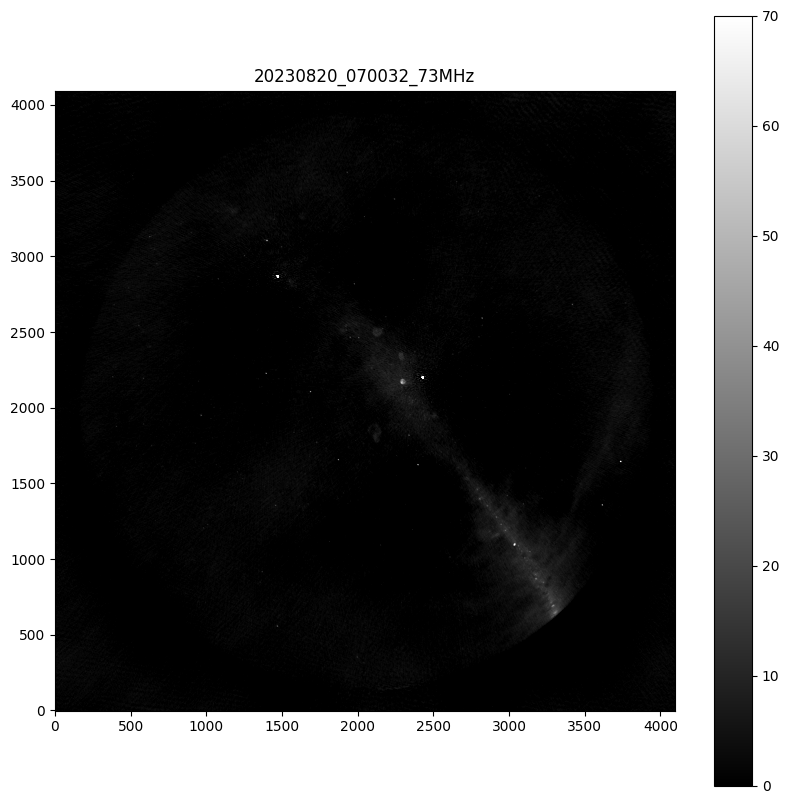

In [66]:
plt.figure(figsize = (10,10))
plt.imshow(image, origin='lower', cmap='gray', vmin = 0, vmax = 70)
plt.title(msfile_prefix)
plt.colorbar()
plt.savefig(os.path.join("/night_snapshot_image/", msfile_prefix + ".png"), dpi = 1200)